# Import Required Packages

In [2]:
import pandas as pd
import numpy as np
from numpy import random 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

# tensorflow & keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

# additional packages for working with directories
from PIL import Image
import os, os.path

In [3]:
# check version and ensure gpu is detected
print(f"TensorFlow Version: {tf.version.VERSION}")
print(f"GPU Check: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.8.0
GPU Check: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Dataset into Keras & Create Class Labels

In [4]:
# single directory holding all images, divided into labels by subfolder names (A, B, C, etc.)
IMAGE_DIR = './data_ASL_200x200_custom3_final'

In [5]:
image_data = [] # 
for folder in os.listdir(IMAGE_DIR):
    
    # label is name of the subfolder (A, B, C, etc.)
    label_folder = os.path.join(IMAGE_DIR, folder)

    # get filepaths and associate with classification 
    filenames = [
        {'label':folder,'filepath':os.path.join(label_folder, f)} 
        for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    
    #print(filenames)

    image_data += filenames

df = pd.DataFrame(image_data)
df.sample(5)


,label,filepath
20783,E,./data_ASL_200x200_custom3_final\E\E2603.jpg
21180,E,./data_ASL_200x200_custom3_final\E\E2961.jpg
5748,B,./data_ASL_200x200_custom3_final\B\B2572.jpg
88097,U,./data_ASL_200x200_custom3_final\U\U2887.jpg
105140,Y,./data_ASL_200x200_custom3_final\Y\Y3825.jpg


In [6]:
#x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
#x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

In [7]:
# split df into train and holdout
X_train, X_holdout = train_test_split(df, test_size=0.15, stratify=df[['label']])

# split train data again, into train test
X_train, X_test = train_test_split(X_train, test_size=0.15, stratify=X_train[['label']])

In [8]:
x_col, y_col = 'filepath', 'label'
image_w, image_h = 64,64
batch_size = 128
num_classes = len(df[y_col].unique())

In [9]:
train_datagen = ImageDataGenerator(
    rescale= 1/255,
    rotation_range=20,  # random rotation range, in degrees
    zoom_range = 0.2, # random zoom range
    width_shift_range=0.1,  # horizontal shift augmentation (fraction of total width)
    height_shift_range=0.1,  # vertical shift augmentation (fraction of total height)
    horizontal_flip=True,  # horizontal flip 
    vertical_flip=True
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col=x_col, y_col=y_col,
    target_size=(image_w,image_h),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
    )

######################################################################################################################################################

validation_datagen = ImageDataGenerator(
    rescale= 1/255,
    rotation_range=20,  # random rotation range, in degrees
    zoom_range = 0.2, # random zoom range
    width_shift_range=0.1,  # horizontal shift augmentation (fraction of total width)
    height_shift_range=0.1,  # vertical shift augmentation (fraction of total height)
    horizontal_flip=True,  # horizontal flip 
    vertical_flip=True
    )

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col=x_col, y_col=y_col,
    target_size=(image_w,image_h),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
    )

######################################################################################################################################################

holdout_datagen = ImageDataGenerator(
    rescale= 1/255,
    rotation_range=20,  # random rotation range, in degrees
    zoom_range = 0.2, # random zoom range
    width_shift_range=0.1,  # horizontal shift augmentation (fraction of total width)
    height_shift_range=0.1,  # vertical shift augmentation (fraction of total height)
    horizontal_flip=True,  # horizontal flip 
    vertical_flip=True
    )

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=X_holdout,
    x_col=x_col, y_col=y_col,
    target_size=(image_w,image_h),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
    )

Found 79475 validated image filenames belonging to 28 classes.
Found 14025 validated image filenames belonging to 28 classes.
Found 16500 validated image filenames belonging to 28 classes.


In [17]:
from glob import glob
class_names = glob('./data_ASL_200x200_custom3_final/*') # Reads all the folders in which images are present
class_names = sorted(class_names) # Sorting them
name_id_map = dict(zip(class_names, range(len(class_names))))


In [18]:
name_id_map

{'./data_ASL_200x200_custom3_final\\A': 0,
 './data_ASL_200x200_custom3_final\\B': 1,
 './data_ASL_200x200_custom3_final\\C': 2,
 './data_ASL_200x200_custom3_final\\D': 3,
 './data_ASL_200x200_custom3_final\\E': 4,
 './data_ASL_200x200_custom3_final\\F': 5,
 './data_ASL_200x200_custom3_final\\G': 6,
 './data_ASL_200x200_custom3_final\\H': 7,
 './data_ASL_200x200_custom3_final\\I': 8,
 './data_ASL_200x200_custom3_final\\J': 9,
 './data_ASL_200x200_custom3_final\\K': 10,
 './data_ASL_200x200_custom3_final\\L': 11,
 './data_ASL_200x200_custom3_final\\M': 12,
 './data_ASL_200x200_custom3_final\\N': 13,
 './data_ASL_200x200_custom3_final\\O': 14,
 './data_ASL_200x200_custom3_final\\P': 15,
 './data_ASL_200x200_custom3_final\\Q': 16,
 './data_ASL_200x200_custom3_final\\R': 17,
 './data_ASL_200x200_custom3_final\\S': 18,
 './data_ASL_200x200_custom3_final\\T': 19,
 './data_ASL_200x200_custom3_final\\U': 20,
 './data_ASL_200x200_custom3_final\\V': 21,
 './data_ASL_200x200_custom3_final\\W': 22

In [11]:
# Create Model
model = Sequential()

# Convolution Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

# Convolution Layer 2
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

# Convolution Layer 3
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

# Convolution Layer 4
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

# flatten
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(28, activation = "softmax"))

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [13]:
early_stop = EarlyStopping(monitor='val_loss',patience=8)
epochs=80

with tf.device('/gpu:0'):
    history = model.fit(train_generator,
        epochs=epochs,
        steps_per_epoch= train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps = validation_generator.samples // batch_size,
        verbose=1,
        callbacks = [early_stop])


Epoch 1/80
620/620 [==============================] - 98s 154ms/step - loss: 2.9524 - accuracy: 0.1190 - val_loss: 2.3627 - val_accuracy: 0.2544
Epoch 2/80
620/620 [==============================] - 95s 153ms/step - loss: 1.9521 - accuracy: 0.3790 - val_loss: 1.4575 - val_accuracy: 0.5445
Epoch 3/80
620/620 [==============================] - 94s 151ms/step - loss: 1.3364 - accuracy: 0.5740 - val_loss: 0.9990 - val_accuracy: 0.6812
Epoch 4/80
620/620 [==============================] - 94s 152ms/step - loss: 1.0608 - accuracy: 0.6591 - val_loss: 0.8569 - val_accuracy: 0.7286
Epoch 5/80
620/620 [==============================] - 93s 151ms/step - loss: 0.9127 - accuracy: 0.7041 - val_loss: 0.6707 - val_accuracy: 0.7866
Epoch 6/80
620/620 [==============================] - 93s 151ms/step - loss: 0.8091 - accuracy: 0.7389 - val_loss: 0.6060 - val_accuracy: 0.8093
Epoch 7/80
620/620 [==============================] - 94s 151ms/step - loss: 0.7312 - accuracy: 0.7630 - val_loss: 0.5876 - val_ac

In [22]:
model.save('final_model.keras')

# Visualize Historical Training/Validation

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

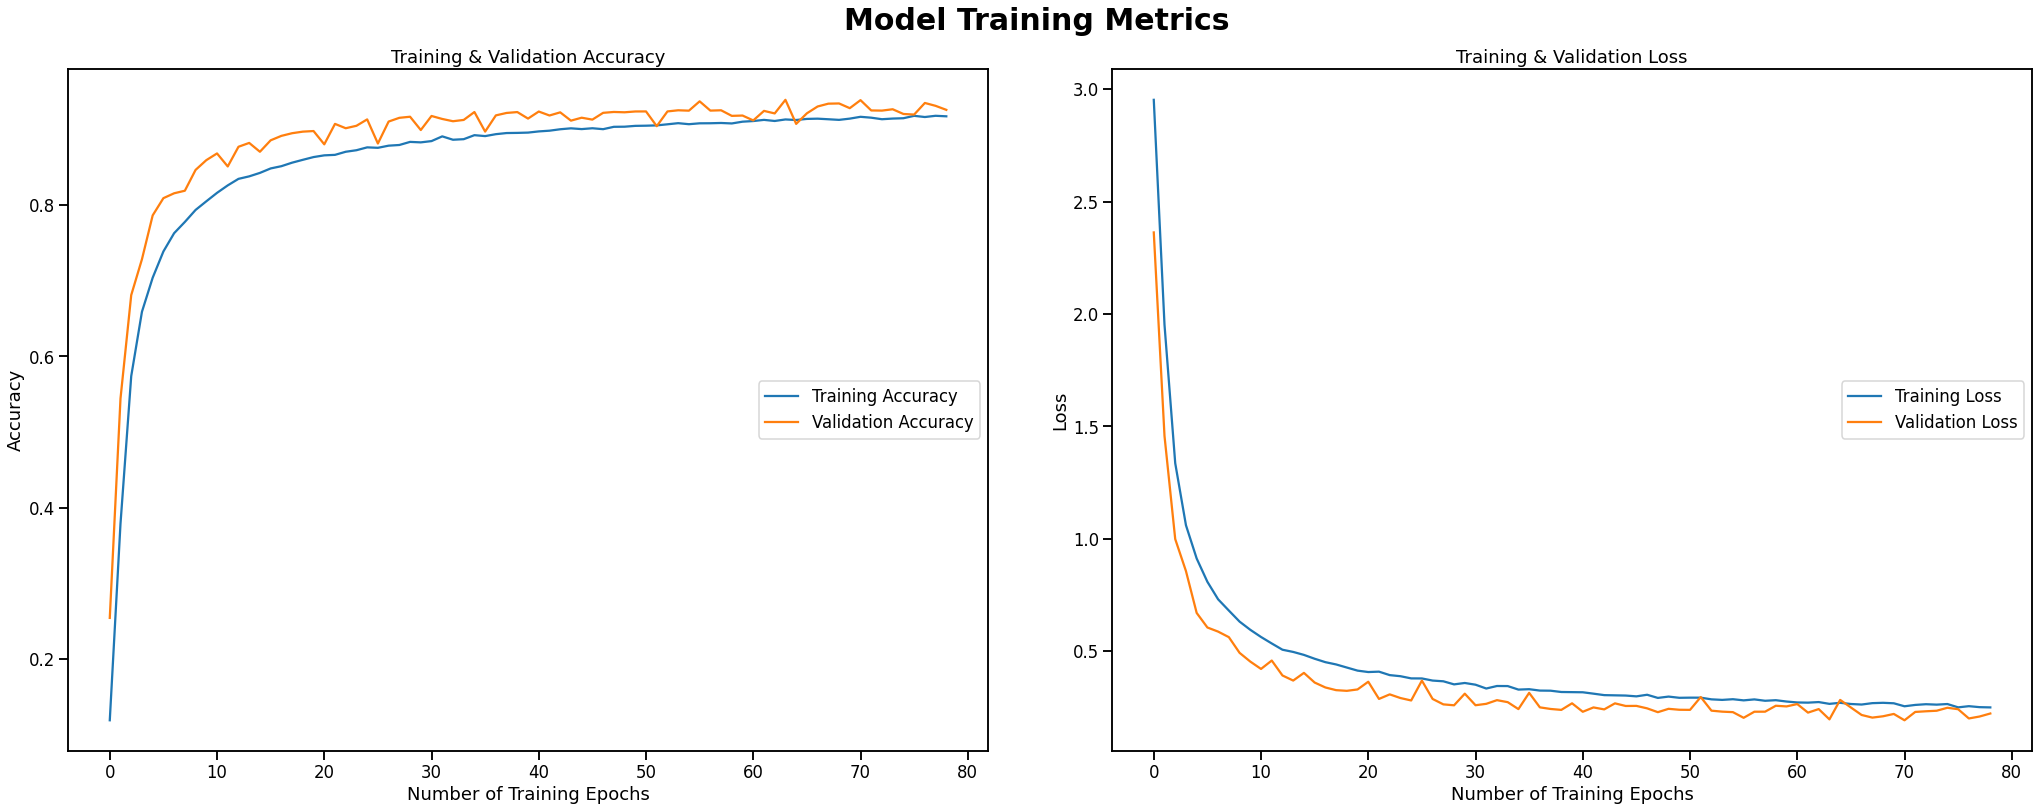

In [49]:
# plot training and validation accuracy/loss
sns.set_context('talk')
fig, ax = plt.subplots(1,2,figsize=(30,12))
fig.tight_layout(pad=4)
fig.suptitle('Model Training Metrics', fontsize=30, fontweight='bold')
ax = ax.ravel()

sns.lineplot(x=epochs, y=acc, label = 'Training Accuracy', ax=ax[0])
sns.lineplot(x=epochs, y=val_acc, label = 'Validation Accuracy', ax=ax[0])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Training Epochs')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend(loc=7)

sns.lineplot(x=epochs, y=loss, label = 'Training Loss', ax=ax[1])
sns.lineplot(x=epochs, y=val_loss, label = 'Validation Loss', ax=ax[1])
ax[1].set_xlabel('Number of Training Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend(loc=7)

# Run Model on the Test Set

In [16]:
predictions = model.predict(holdout_generator, verbose=1)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

129/129 [==============================] - 17s 132ms/step
              precision    recall  f1-score   support

           A       0.97      0.90      0.93       600
           B       0.96      0.93      0.94       600
           C       0.96      0.93      0.95       600
           D       0.94      0.97      0.95       600
           E       0.88      0.96      0.92       600
           F       0.99      0.97      0.98       600
           G       0.92      0.98      0.95       600
           H       0.92      0.95      0.94       600
           I       0.91      0.92      0.91       600
           J       0.94      0.90      0.92       600
           K       0.94      0.94      0.94       600
           L       0.97      0.92      0.94       600
           M       0.89      0.94      0.92       600
           N       0.97      0.86      0.91       600
           O       0.97      0.96      0.96       600
           P       0.90      0.96      0.93       600
           Q       0.98

Text(23.690000000000005, 0.5, 'Actual')

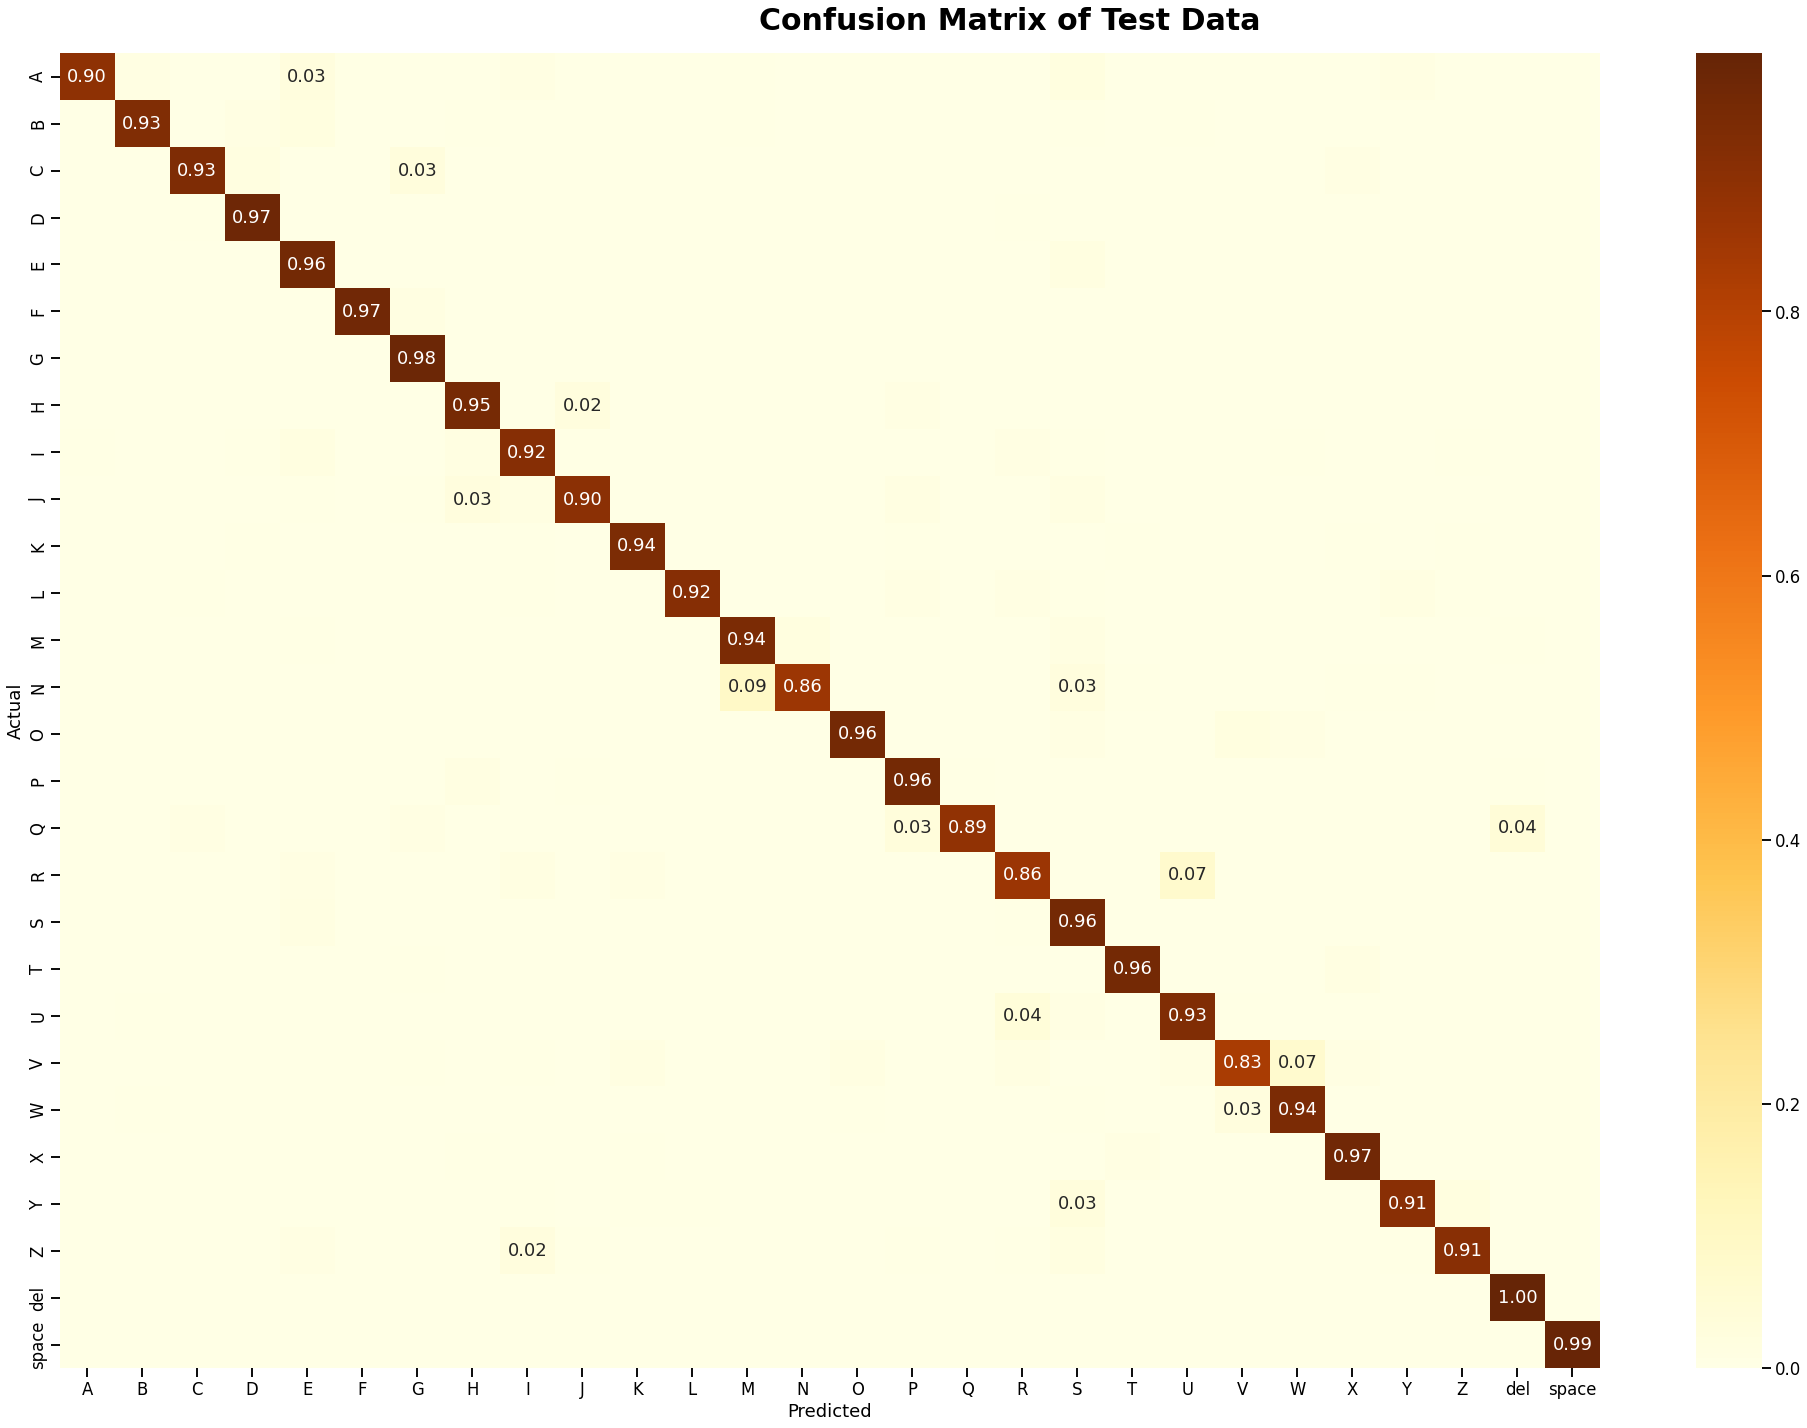

In [130]:
# create normalized confusion matrix
cm = confusion_matrix(true_classes,predicted_classes)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# visualize
fig, ax = plt.subplots(figsize=(28, 20))
fig.suptitle('Confusion Matrix of Test Data', fontsize='30', fontweight='bold')
fig.tight_layout()
cmap = sns.color_palette("YlOrBr", as_cmap=True)



# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
annot_labels = np.empty_like(normalized_cm, dtype=str)
annot_mask = normalized_cm > 0.5
annot_labels[annot_mask] = '1'

annot_labels = normalized_cm
thresholded_annot_labels = normalized_cm > 0.02


ax = sns.heatmap(normalized_cm, annot=annot_labels, fmt='.2f', cmap=cmap)

for text, show_annot in zip(ax.texts, (element for row in thresholded_annot_labels for element in row)):
    text.set_visible(show_annot)


ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')